In [6]:
import os
import csv
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Flatten, Dense

# Load the image paths and steering angles
def load_data(image_dir, csv_file):
    image_paths = []
    steering_angles = []

    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            image_path = os.path.join(image_dir, row["Image Name"])
            if os.path.exists(image_path):
                image_paths.append(image_path)
                steering_angles.append(float(row["Steering Angle"]))

    return image_paths, steering_angles

# Image preprocessing
def preprocess_image(image):
    # Resize the image to the input shape expected by the network (66x200)
    resized_image = cv2.resize(image, (200, 66))
    # Convert the image to YUV color space (as in the NVIDIA model)
    yuv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YUV)
    # Normalize the image to the range [-1, 1]
    normalized_image = yuv_image / 127.5 - 1.0
    return normalized_image

# Data augmentation functions
def random_flip(image, steering_angle):
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = 0.25 + np.random.uniform()
    hsv[:, :, 2] = hsv[:, :, 2] * brightness
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return image

def random_shift(image, steering_angle, range_x=100, range_y=10):
    trans_x = range_x * (np.random.uniform() - 0.5)
    trans_y = range_y * (np.random.uniform() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

def random_shadow(image):
    top_y = 320 * np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320 * np.random.uniform()
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    shadow_mask = 0 * image_hls[:, :, 1]
    X_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    shadow_mask[((X_m - top_x) * (bot_y - top_y) - (bot_x - top_x) * (X_m - top_y) >= 0)] = 1
    random_bright = 0.5
    cond1 = shadow_mask == 1
    cond0 = shadow_mask == 0
    if np.random.randint(2) == 1:
        image_hls[:, :, 1][cond1] = image_hls[:, :, 1][cond1] * random_bright
    else:
        image_hls[:, :, 1][cond0] = image_hls[:, :, 1][cond0] * random_bright
    image = cv2.cvtColor(image_hls, cv2.COLOR_HLS2BGR)
    return image

# Generator to yield batches of data with augmentation
def data_generator(image_paths, steering_angles, batch_size=32, training=True):
    while True:
        X_batch = []
        y_batch = []
        for i in range(batch_size):
            index = np.random.randint(0, len(image_paths))
            image_path = image_paths[index]
            image = cv2.imread(image_path)
            steering_angle = steering_angles[index]

            if training:
                image, steering_angle = random_flip(image, steering_angle)
                image = random_brightness(image)
                image, steering_angle = random_shift(image, steering_angle)
                image = random_shadow(image)

            image = preprocess_image(image)
            X_batch.append(image)
            y_batch.append(steering_angle)
        yield (np.array(X_batch), np.array(y_batch))

# Load data
image_dir = "images"
csv_file = "image_data.csv"
image_paths, steering_angles = load_data(image_dir, csv_file)

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.25)

# Validate the shapes of the data
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_valid)}")
print(f"Shape of y_train: {np.shape(y_train)}")
print(f"Shape of y_valid: {np.shape(y_valid)}")

Number of training samples: 2562
Number of validation samples: 854
Shape of y_train: (2562,)
Shape of y_valid: (854,)


In [7]:
import matplotlib.pyplot as plt

def plot_loss_history(loss_history: dict[str, list[float]]):
    loss = loss_history["loss"]
    val_loss = loss_history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b--", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [8]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# Define the NVIDIA model
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(66, 200, 3)))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    return model

lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.5 if epoch % 8 == 0 and epoch // 8 > 0 else lr)

# Compile the model
model = nvidia_model()
model.compile(loss='mse', optimizer=Adam(learning_rate=5e-4))

In [9]:
# Create data generators
batch_size = 32
train_generator = data_generator(X_train, y_train, batch_size=batch_size, training=True)
valid_generator = data_generator(X_valid, y_valid, batch_size=batch_size, training=False)

# Train the model
history = model.fit(train_generator,
                    callbacks=[lr_scheduler],
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=valid_generator,
                    validation_steps=len(X_valid) // batch_size,
                    epochs=30)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0078 - val_loss: 0.0049 - learning_rate: 5.0000e-04
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0056 - val_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0059 - val_loss: 0.0053 - learning_rate: 5.0000e-04
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0057 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0054 - val_loss: 0.0070 - learning_rate: 5.0000e-04
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0055 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0051 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0047 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0053 - val_loss: 0.0036 - learning_

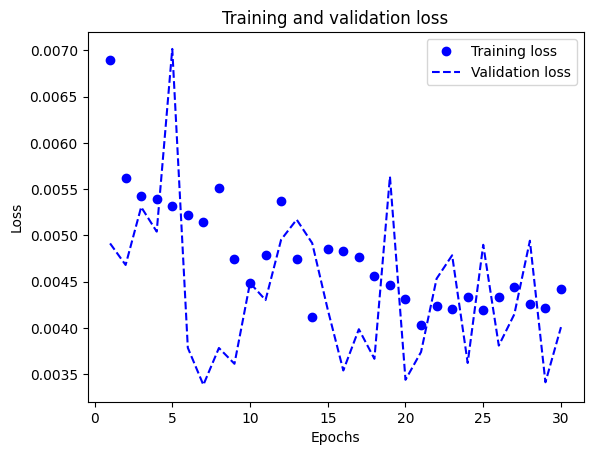

In [10]:
plot_loss_history(history.history)

In [11]:
model.save("autonomous_vehicle_model_augmented.keras")